**Imports**

In [334]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import networkx as nx
from scipy.spatial.distance import pdist, squareform

**Koordinaten importieren und hinzufügen der neuen Wasserpumpe ins DF**

In [335]:
df = pd.read_excel("Erdbeerfelder.xlsx", sheet_name=0, skiprows=1, usecols="C:D",names=["x","y"])
df = df.astype(float)
df= df.append({"x":10,"y":10},ignore_index=True)

/var/folders/4z/c2y3b6j9799gk1l74sc986mw0000gn/T/ipykernel_27561/3766332710.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df= df.append({"x":10,"y":10},ignore_index=True)


**Erstellung der Distanzmatrix (euklidische Distanz)**

In [336]:
# Berechnung der Distanzmatrix
dist_matrix = squareform(pdist(df))

**Erstellen des Netzwerkes mit networkX**

In [337]:
# Erstellung des Netzwerks
G = nx.Graph()

# Hinzufügen der Knoten
for i in range(len(df)):
    G.add_node(i,x=df["x"][i], y=df["y"][i])

# Hinzufügen der Kanten mit den Distanzen als Gewicht
for i in range(len(df)):
    for j in range(len(df)):
        G.add_edge(i, j, weight=dist_matrix[i][j])

**Berechnung des minimalen Spannbaums und des zugehörigen Schlauchlänge**

In [338]:

# Berechnung des minimalen Spannbaums
T = nx.minimum_spanning_tree(G)
total_length = 0
for u, v in T.edges():
    total_length += G[u][v]['weight']


**Visualisierung**

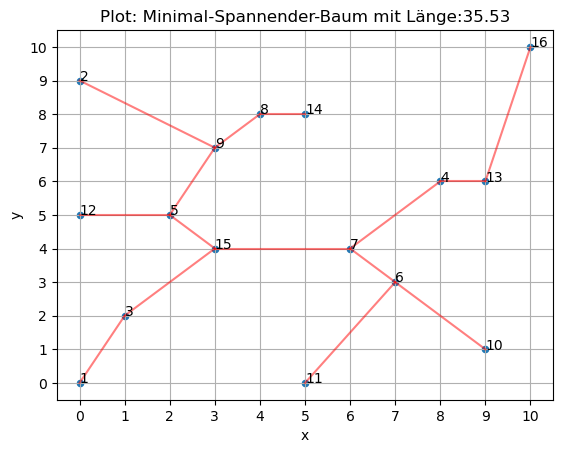

In [339]:

# Scatter-Plot
plt.scatter(df["x"], df["y"], s=20)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Plot: Minimal-Spannender-Baum mit Länge:" + str(round(total_length,2)))
plt.grid(True)

# Anmerkungen für die Punkte
for i, txt in enumerate(df.index):
    plt.annotate(txt + 1, (df["x"][i], df["y"][i]))

# Zeichnen der Kanten des minimalen Spannbaums
for (u, v) in T.edges():
    x1, y1 = G.nodes[u]["x"], G.nodes[u]["y"]
    x2, y2 = G.nodes[v]["x"], G.nodes[v]["y"]
    plt.plot([x1, x2], [y1, y2], 'r-', alpha=0.5)

plt.xticks(range(0, 11, 1))
plt.yticks(range(0, 11, 1))

plt.show()

Hier sieht man den minimal spannenden Baum mit der Wasserpumpe in (0,0) und (10,0).  Die Schlauchlänge beträgt 35,53 und stellt eine Obergrenze dar.

**Idee 1** <br>
Es wird die Bedingung gestellt, dass beide Pumpen jeweils eine bestimmte Anzahl von Erdbeeren bewässern, d.h. es müssen zwei minimale spannende Bäume vorhanden sein.
Es wird der Reihe nach durch die Knoten iteriert und geprüft, ob der Knoten zum (0,0)-Baum oder zum (10,10)-Baum gehört. Dazu wird getestet, welcher Baum nach Hinzufügen des Knotens weniger schwerer wurde ist.

In [340]:
array__pumpe_1= []
array__pumpe_1.append(0)
array_pumpe_2= []
# Die Pumpe im Punkt (10,10) soll in einer eigenen Liste sein
array_pumpe_2.append(15)

for index in range(1, 15):
    temp_array_1 = array__pumpe_1 + [index]
    temp_array_2 = array_pumpe_2 + [index]
    
    #Checken welcher Baum minimaler nach einfügend des Knoten ist (< oder <= macht kein Unterschied aufs Endergebnis)
    if array_to_mst_value(temp_array_1) < array_to_mst_value(temp_array_2):
        array__pumpe_1.append(index)
    else:
        array_pumpe_2.append(index)

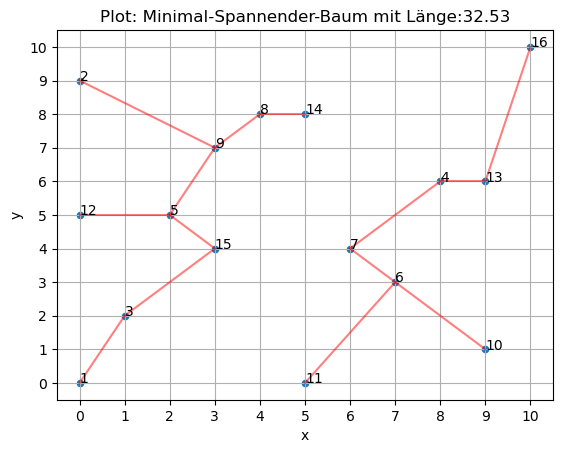

In [341]:
plot_minimum_spanning_tree(array__pumpe_1,array_pumpe_2)

**Ergebnis:**<br> 
Mit Idee 1 erhalten wir zwei minimalspannde Bäume, welche zusammen eine schlauch Länge von 32,53 benötigen. Die Pumpen befinden sich in den Punkten 1 und 16.

**Idee 2:** <br> Einen minimalen spannenden Baum zwischen allen Punkten (auch Pumpe (10,10)) erstellen. Dann den Pfad zwischen (0,0) und (10,10) suchen. Iterativ jede Kante auf dem Pfad einmal entfernen. 
Dadurch entstehen zwei Bäume, welche in der Summe der Gewichte (Länge der Schläuche) minimal werden soll.

In [342]:
# Finde den kürzesten Pfad zwischen den Punkten (0,0) und (10,10)
path = nx.shortest_path(T, source=0, target=15, weight='weight')

**Visualisierung**

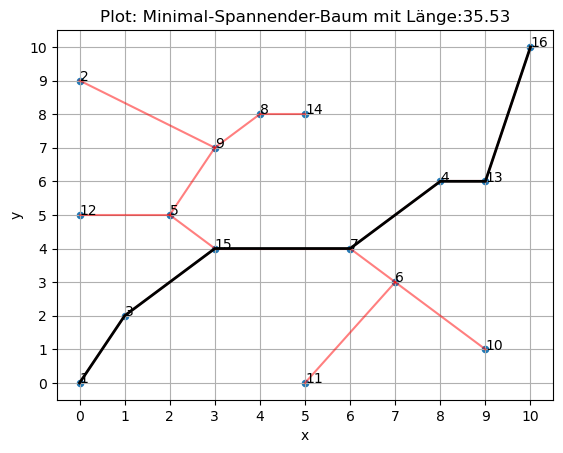

In [343]:

# Scatter-Plot
plt.scatter(df["x"], df["y"], s=20)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Plot: Minimal-Spannender-Baum mit Länge:" + str(round(total_length,2)))
plt.grid(True)

# Anmerkungen für die Punkte
for i, txt in enumerate(df.index):
    plt.annotate(txt + 1, (df["x"][i], df["y"][i]))

# Zeichnen der Kanten des minimalen Spannbaums
for (u, v) in T.edges():
    x1, y1 = G.nodes[u]["x"], G.nodes[u]["y"]
    x2, y2 = G.nodes[v]["x"], G.nodes[v]["y"]
    plt.plot([x1, x2], [y1, y2], 'r-', alpha=0.5)

# Path zeichnen
x_path = df.loc[path]["x"].tolist()
y_path = df.loc[path]["y"].tolist()
plt.plot(x_path, y_path, 'k-', linewidth=2)

plt.xticks(range(0, 11, 1))
plt.yticks(range(0, 11, 1))

plt.show()



- Gehe jede Kante auf dem Weg iterativ ab <br>
- Entferne sie <br> 
- Erhalte zwei neue minimal spannende Bäume <br>
- Berechne die Summe der beiden längen

In [344]:
min_path={}
# Iteriere durch alle Kanten auf dem Pfad
for i in range(len(path) - 1):
    dict_temp= {}
    T_copy = T.copy()

    # Entferne die aktuelle Kante i mit i+1
    T_copy.remove_edge(path[i], path[i+1])

    # Finde die zusammenhängenden Komponenten (d.h., die beiden Bäume)
    components = list(nx.connected_components(T_copy))

    # Der erste Baum ist die erste Komponente
    tree1 = T_copy.subgraph(components[0])

    # Der zweite Baum ist die zweite Komponente
    tree2 = T_copy.subgraph(components[1])

    # Alle Knoten des ersten Baums hinzufügen
    tree1_nodes = tree1.nodes()

    # Alle Knoten des zweiten Baums hinzufügen
    tree2_nodes = tree2.nodes()

    #Werte ins Dict hinzufügen
    dict_temp["tree1_nodes"]=list(tree1_nodes)
    dict_temp["tree2_nodes"]=list(tree2_nodes)
    dict_temp["value"]=array_to_mst_value(tree2_nodes)+array_to_mst_value(tree1_nodes)

    min_path[(path[i], path[i+1])]=dict_temp


Abbildung 1 :


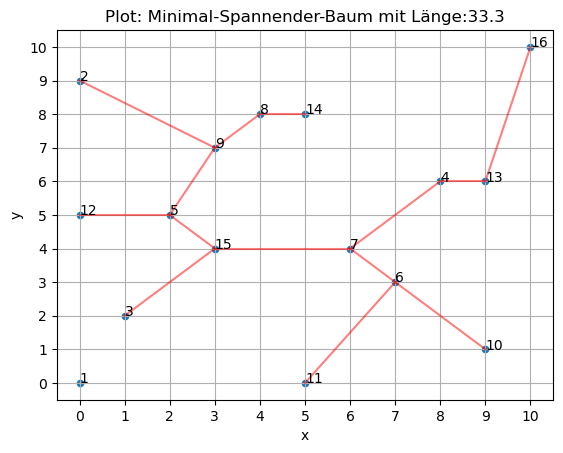

Abbildung 2 :


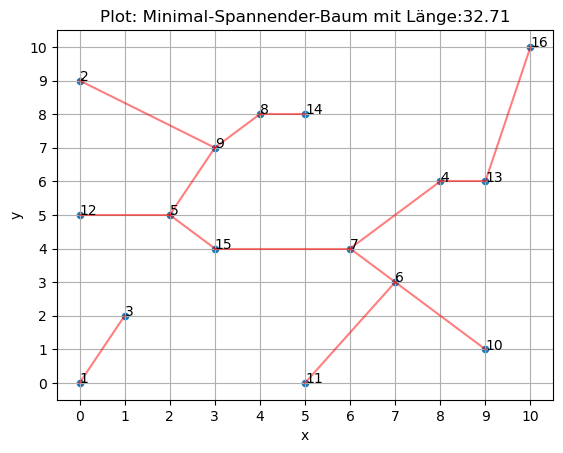

Abbildung 3 :


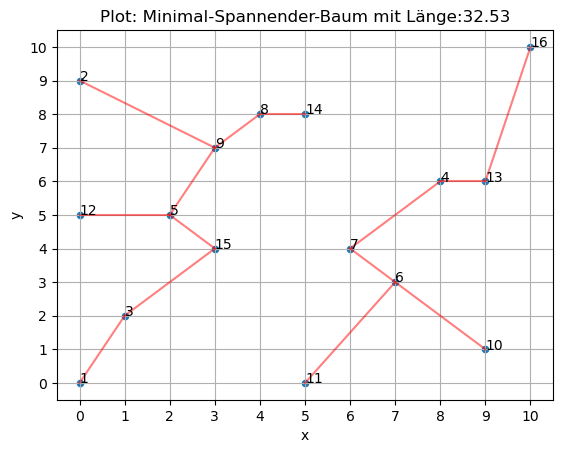

Abbildung 4 :


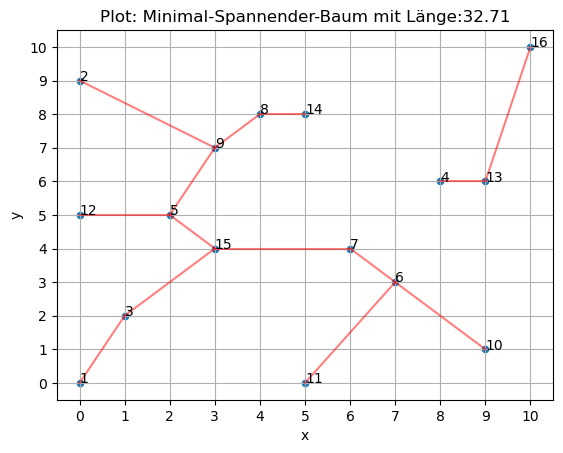

Abbildung 5 :


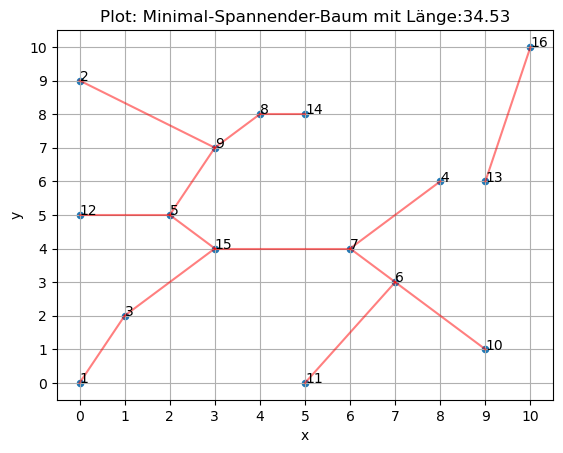

Abbildung 6 :


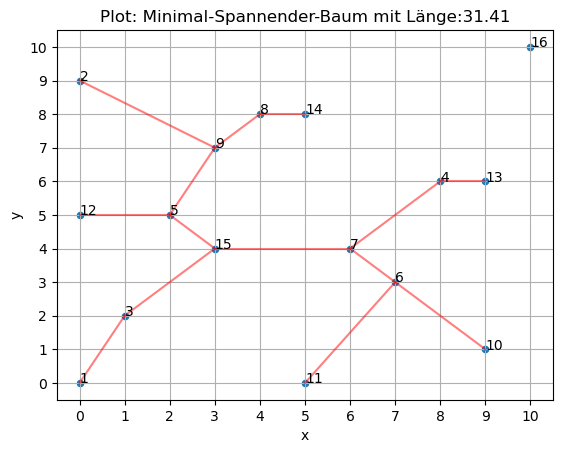

In [349]:
i=1
for edge, data in min_path.items():
    print("Abbildung "+ str(i) +" :")
    tree1_nodes = data['tree1_nodes']
    tree2_nodes = data['tree2_nodes']
    plot_minimum_spanning_tree(tree1_nodes,tree2_nodes)
    i+=1


**Ergebnis**<br>
Die kürzeste gesamt Schlauchlänge erhalten wir bei Abbildung 6.<br>
Damit lässt sich Aufgabe a3) wie folgt beantworten:<br>
- Die gesamt minimale Schlauchlänge beträgt 31.41
-  Eine Wasserpumpe befindet sich im Punkt 1 und bewässert alle Punkte bis 15. 
- die zweite Wasserpumpe befindet sich im Punkt 16, ist aber nicht angeschlossen

In [346]:
def array_to_mst_value(array):
    # Erstellung des Netzwerks
    G_temp = nx.Graph()

    # Hinzufügen der Knoten
    for element in array:
        G_temp.add_node(element,x=df["x"][element], y=df["y"][element])

    # Hinzufügen der Kanten mit den Distanzen als Gewicht
    for i in array:
        for j in array:
            G_temp.add_edge(i, j, weight=dist_matrix[i][j])

    # Berechnung des minimalen Spannbaums
    T = nx.minimum_spanning_tree(G_temp)
    total_length_0 = 0
    for u, v in T.edges():
        total_length_0 += G_temp[u][v]['weight']

    return total_length_0

In [347]:
def dataframe_to_Graph(df_x):
    # Berechnung der Distanzmatrix
    dist_matrix_x = squareform(pdist(df_x))

    # Erstellung des Netzwerks
    G_x = nx.Graph()

    # Hinzufügen der Knoten
    for i in range(len(df_x)):
        G_x.add_node(i,x=df_x["x"][i], y=df_x["y"][i])

    # Hinzufügen der Kanten mit den Distanzen als Gewicht
    for i in range(len(df_x)):
        for j in range(len(df_x)):
            G_x.add_edge(i, j, weight=dist_matrix_x[i][j])


    return G_x


In [348]:
def plot_minimum_spanning_tree(array_pumpe_1, array_pumpe_2):
    # Erstes DataFrame mit den Indizes aus array_pumpe_1 erstellen
    df1 = df.loc[array_pumpe_1].copy().reset_index(drop=True)
    # Zweites DataFrame mit den Indizes aus array_pumpe_2 erstellen
    df2 = df.loc[array_pumpe_2].copy().reset_index(drop=True)

    Graph_Pumpe1 = dataframe_to_Graph(df1)
    Graph_Pumpe2 = dataframe_to_Graph(df2)

    # Berechnung des minimalen Spannbaums für Pumpe 1
    T_1 = nx.minimum_spanning_tree(Graph_Pumpe1)
    total_length_1 = sum(Graph_Pumpe1[u][v]['weight'] for u, v in T_1.edges())

    # Berechnung des minimalen Spannbaums für Pumpe 2
    T_2 = nx.minimum_spanning_tree(Graph_Pumpe2)
    total_length_2 = sum(Graph_Pumpe2[u][v]['weight'] for u, v in T_2.edges())

    # Scatter-Plot
    plt.scatter(df["x"], df["y"], s=20)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Plot: Minimal-Spannender-Baum mit Länge:" + str(round(total_length_1 + total_length_2, 2)))
    plt.grid(True)

    # Punkte plotten. Index +1, da wir hier mit 0 anfangen zu zählen
    for i, txt in enumerate(df.index):
        plt.annotate(txt + 1, (df["x"][i], df["y"][i]))

    # Zeichnen der Kanten des minimalen Spannbaums für Pumpe 1
    for (u, v) in T_1.edges():
        x1, y1 = Graph_Pumpe1.nodes[u]["x"], Graph_Pumpe1.nodes[u]["y"]
        x2, y2 = Graph_Pumpe1.nodes[v]["x"], Graph_Pumpe1.nodes[v]["y"]
        plt.plot([x1, x2], [y1, y2], 'r-', alpha=0.5)

    # Zeichnen der Kanten des minimalen Spannbaums für Pumpe 2
    for (u, v) in T_2.edges():
        x1, y1 = Graph_Pumpe2.nodes[u]["x"], Graph_Pumpe2.nodes[u]["y"]
        x2, y2 = Graph_Pumpe2.nodes[v]["x"], Graph_Pumpe2.nodes[v]["y"]
        plt.plot([x1, x2], [y1, y2], 'r-', alpha=0.5)

    plt.xticks(range(0, 11, 1))
    plt.yticks(range(0, 11, 1))
    plt.show()